In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 16s 205ms/step - loss: 0.6214 - root_mean_squared_error: 0.7883 - val_loss: 0.4354 - val_root_mean_squared_error: 0.6599
Epoch 2/50
53/53 [==============================] - 9s 180ms/step - loss: 0.2976 - root_mean_squared_error: 0.5455 - val_loss: 0.2508 - val_root_mean_squared_error: 0.5008
Epoch 3/50
53/53 [==============================] - 9s 180ms/step - loss: 0.1530 - root_mean_squared_error: 0.3912 - val_loss: 0.2209 - val_root_mean_squared_error: 0.4700
Epoch 4/50
53/53 [==============================] - 10s 185ms/step - loss: 0.1491 - root_mean_squared_error: 0.3861 - val_loss: 0.2157 - val_root_mean_squared_error: 0.4644
Epoch 5/50
53/53 [==============================] - 10s 184ms/step - loss: 0.1393 - root_mean_squared_error: 0.3732 - val_loss: 0.2038 - val_root_mean_squared_error: 0.4515
Epoch 6/50
53/53 [==============================] - 9s 170ms/step - loss: 0.1310 - root_mean_squared_error: 0.3619 - val_loss: 0.1922 - v

Epoch 30/50
53/53 [==============================] - 9s 177ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2012
Epoch 31/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0348 - root_mean_squared_error: 0.1865 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1794
Epoch 32/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0445 - val_root_mean_squared_error: 0.2110
Epoch 33/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0342 - root_mean_squared_error: 0.1849 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1747
Epoch 34/50
53/53 [==============================] - 1s 23ms/step - loss: 0.0342 - root_mean_squared_error: 0.1848 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1794
Epoch 35/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0323 - root_mean_squared_error: 0.1797 - val_loss: 0.0382 -

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.835208900769552 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

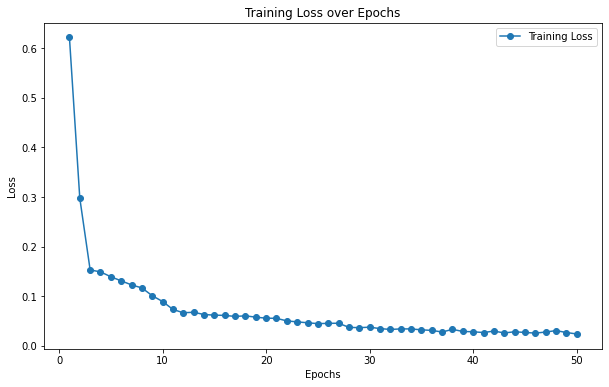

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

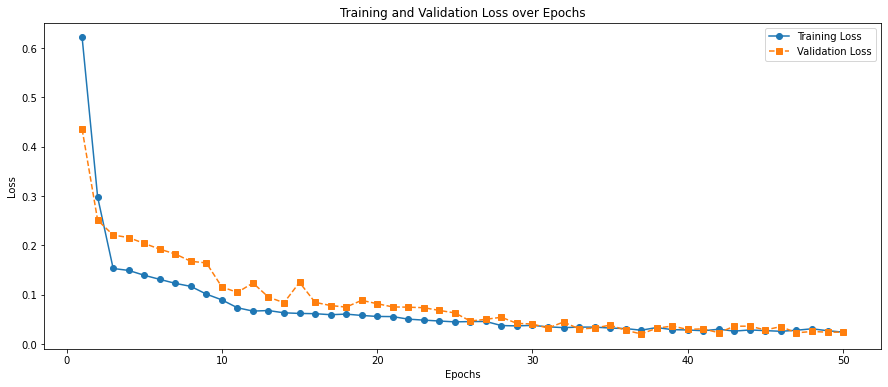

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 12ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.13213063116204385
MAE : 0.0935196819972094


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,954864.000000,906368.363
1,972187.687500,917403.622
2,937594.000000,910653.838
3,897156.500000,822319.125
4,770893.812500,557314.102
5,512968.656250,197129.525
6,196337.671875,75730.217
7,101754.710938,59608.479
8,211669.484375,88785.283
9,519906.218750,396883.400


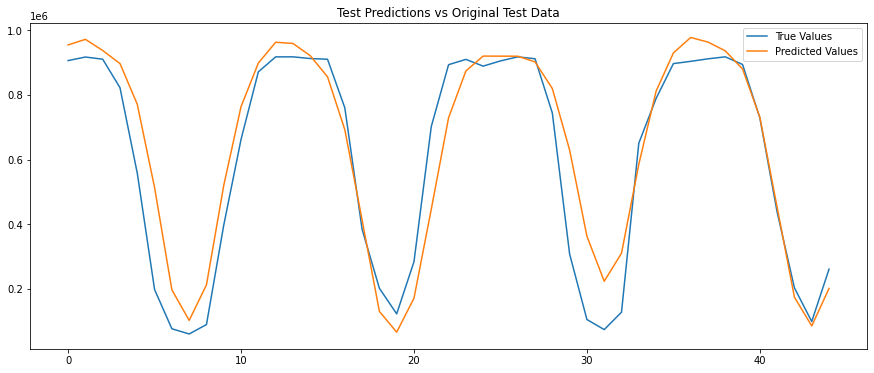

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 10ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

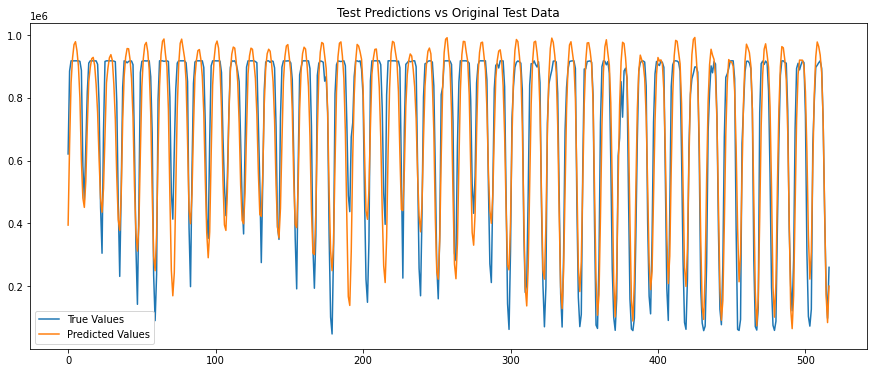

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()